To run this notebook, please select julia as the default interpreter!

In [1]:
# Import some libraries
include("LargeSystems/system.jl")
include("Utils/Layered.jl")
include("evaluation-tools.jl")

# Set our domain constants
const L::Float64 = 10.0
const tf::Float64 = .1

0.1

Below is the code to build the Lax-Wendorff system

In [2]:
function build_system(M::Integer, N::Integer, u0::Function, a::Float64, tf::Float64)
    # Build the system over an M×N grid
    Δx = L / (M + 1)
    Δt = tf / (N + 1)

    # Initialize the variables and the system
    U = ["U$j,$n" for j in range(1, M+1), n in range(1, N+1)]
    system = System(U)
    U = Layered{Tuple{Integer, Integer}, Union{Linear, Number}}([V(U[j,n]) for j in range(1, M+1), n in range(1, N+1)])

    # Initial conditions
    for j in range(0, M + 2)
        U[j, 0] = u0(Δx * j)
    end

    # Initialize our boundary
    for n in range(1, N + 1)
        U[0, n] = U[M + 1, n]
        U[M + 2, n] = U[1, n]
    end

    # Now, we add our schema
    for n in range(0, N)
        for j in range(1, M+1)
            add_constraint!(system, U[j,n+1] == U[j,n] - a * Δt / (2 * Δx) * (U[j+1,n] - U[j-1,n]) 
                                                + a^2 * Δt^2 / (2 * Δx^2) * (U[j-1,n] - 2U[j,n] + U[j+1,n]))
        end
    end

    return system
end

build_system (generic function with 1 method)

First, lets look what happens for a = 20, and with a smooth bell function

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=20,upwind.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=20,upwind.gif")
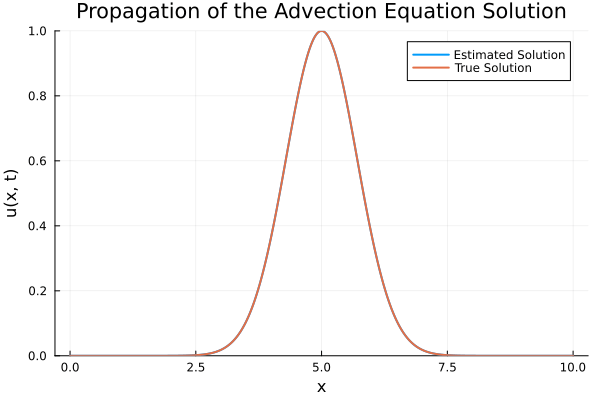

In [3]:
# First, lets take a look at our solution where u0 is a bell
u0(x::Float64) = exp(-(x-L/2)^2)

# To avoid boilerplate, create a plugin
a = 20.0
tf = .1
plug = plugin(u0, a, tf)

# Now, we can plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=20,upwind.gif")

And now for negative velocity:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=-20,downwind.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=-20,downwind.gif")
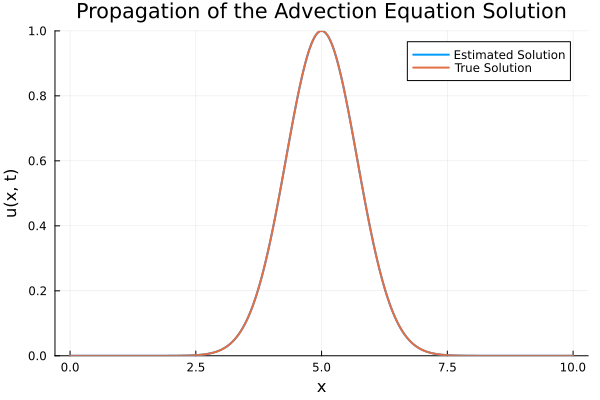

In [4]:
# Lets try for a = -20
a = -20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=-20,downwind.gif")

And lets see what our order of convergence is...

In [5]:
evaluate_Ns(build_system, u0, a, tf, 30, 40, 50, 60, 70, 80, 90, 100)

[0.0007181577130840597, 0.00039641037538375417, 0.00025066301221000393, 0.0001726313440678936, 0.0001260685745921017, 9.608477416285293e-5, 7.565515905923275e-5, 6.111573873855545e-5]
The estimated order of convergence was 2.0843487613123717


This corresponds to $O(n^2)$ convergence, better! Now, lets add some shock to our solution:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=20,shock.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=20,shock.gif")
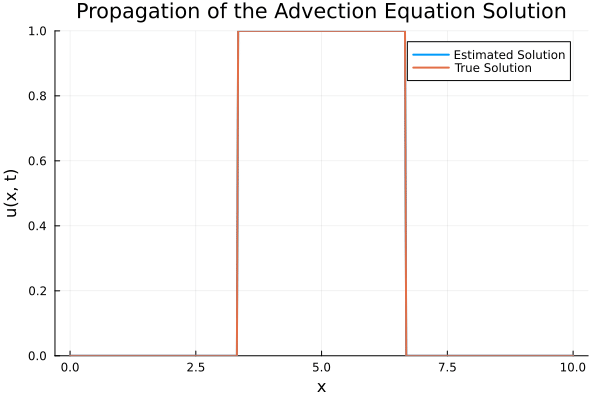

In [4]:
# Lets try a solution with some shock
u0(x::Float64) = L/3 < x < 2L/3 ? 1.0 : 0.0
a = 20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=20,shock.gif")

and with negative velocity:

┌ Info: Saved animation to c:\Users\Atech\Dropbox\Numerical PDEs\HW\HW3 Files\LargeSystems-Julia\a=-20,shock.gif
└ @ Plots C:\Users\Atech\.julia\packages\Plots\HyyIK\src\animation.jl:156


Plots.AnimatedGif("c:\\Users\\Atech\\Dropbox\\Numerical PDEs\\HW\\HW3 Files\\LargeSystems-Julia\\a=-20,shock.gif")
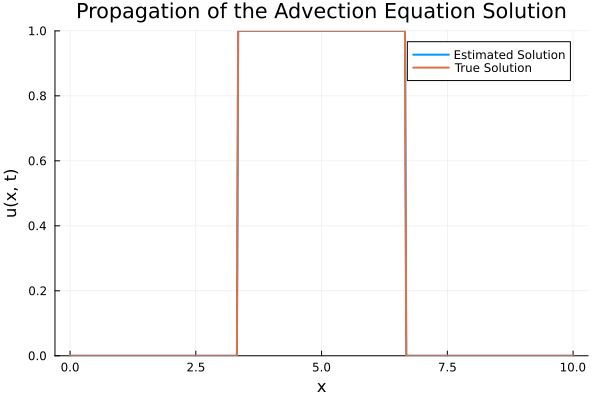

In [5]:
# Lets try for a = -20
a = -20.0
plug = plugin(u0, a, tf)

# Plot the solution
solution = plug(solve_system)(build_system, 400, 100)
plug(plot_solution)(solution, "a=-20,shock.gif")

We can see that there are some bumps forming around our shocks. Now lets estimate the convergence again

In [6]:
evaluate_Ns(build_system, u0, a, tf, 30, 40, 50, 60, 70, 80, 90, 100)

[0.07290777014338774, 0.06636498520672325, 0.06689752057379425, 0.05813966223550531, 0.05500560008242911, 0.05641989353268103, 0.05104580316141884, 0.049455501630519844]
The estimated order of convergence was 0.3285952036220285
